<a href="https://colab.research.google.com/github/Pager07/TensorflowSpecialization/blob/master/C2W3_TansferLearningAndDropout.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Downloading Inception Network Weights

In [1]:
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
    -O /tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5

--2020-07-24 19:22:38--  https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 64.233.167.128, 64.233.166.128, 108.177.15.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|64.233.167.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87910968 (84M) [application/x-hdf]
Saving to: ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’

/tmp/inception_v3_w 100%[===================>]  83.84M  46.8MB/s    in 1.8s    

2020-07-24 19:22:41 (46.8 MB/s) - ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’ saved [87910968/87910968]



#Transfer Learning

In [2]:
import os 
from tensorflow.keras import layers 
from tensorflow.keras import Model
from tensorflow.keras.applications.inception_v3 import InceptionV3

local_weights_file = '/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

pre_trained_model = InceptionV3(input_shape=(150,150,3),
                                include_top = False, #inception has some Dense layer at the start before conv layer. We dont want it 
                                weights  = None)

pre_trained_model.load_weights(local_weights_file)

for layer in pre_trained_model.layers: #lock all the layers 
  layer.trainable = False

#pre_trained_model.summary()

last_layer = pre_trained_model.get_layer('mixed7')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output


last layer output shape:  (None, 7, 7, 768)


In [3]:
from tensorflow.keras.optimizers import RMSprop
#We do not want to use the the dense layer at the end. We we make our own dense layer, 
#so that we can define new numbers prediction class
x = layers.Flatten()(last_output)
x = layers.Dense(units=1024, activation='relu')(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(units=1, activation='sigmoid')(x)

model = Model(pre_trained_model.input, x )
model.compile(loss='binary_crossentropy',optimizer=RMSprop(lr=0.0001),
              metrics = ['accuracy'])

#Data Preporcessing

In [12]:
!wget --no-check-certificate \
        https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
       -O /tmp/cats_and_dogs_filtered.zip

from tensorflow.keras.preprocessing.image import ImageDataGenerator

import os
import zipfile

local_zip = '//tmp/cats_and_dogs_filtered.zip'

zip_ref = zipfile.ZipFile(local_zip, 'r')

zip_ref.extractall('/tmp')
zip_ref.close()

# Define our example directories and files
base_dir = '/tmp/cats_and_dogs_filtered'

train_dir = os.path.join( base_dir, 'train')
validation_dir = os.path.join( base_dir, 'validation')


train_cats_dir = os.path.join(train_dir, 'cats') # Directory with our training cat pictures
train_dogs_dir = os.path.join(train_dir, 'dogs') # Directory with our training dog pictures
validation_cats_dir = os.path.join(validation_dir, 'cats') # Directory with our validation cat pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')# Directory with our validation dog pictures

train_cat_fnames = os.listdir(train_cats_dir)
train_dog_fnames = os.listdir(train_dogs_dir)

train_datagen = ImageDataGenerator(rescale=1/255,
                                   rotation_range=40,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range = 0.2,
                                   zoom_range= 0.2,
                                   horizontal_flip = True)
validation_datagen = ImageDataGenerator(rescale= 1/255)

train_generator = train_datagen.flow_from_directory(train_dir,
                                                    target_size= (150,150),
                                                    batch_size = 20,
                                                    class_mode = 'binary')

validation_generator = validation_datagen.flow_from_directory(validation_dir, 
                                                             target_size = (150,150),
                                                             batch_size= 20,
                                                             class_mode = 'binary')


--2020-07-24 19:30:57--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 64.233.166.128, 108.177.15.128, 173.194.76.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|64.233.166.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘/tmp/cats_and_dogs_filtered.zip’

/tmp/cats_and_dogs_ 100%[===================>]  65.43M   139MB/s    in 0.5s    

2020-07-24 19:30:58 (139 MB/s) - ‘/tmp/cats_and_dogs_filtered.zip’ saved [68606236/68606236]

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [13]:
history = model.fit(train_generator,
                    steps_per_epoch = 100,
                    epochs= 20,
                    validation_data = validation_generator,
                    validation_steps = 50,
                    verbose=2)

Epoch 1/20
100/100 - 23s - loss: 0.2291 - accuracy: 0.9155 - val_loss: 0.0876 - val_accuracy: 0.9600
Epoch 2/20
100/100 - 22s - loss: 0.1957 - accuracy: 0.9220 - val_loss: 0.1512 - val_accuracy: 0.9500
Epoch 3/20
100/100 - 21s - loss: 0.2095 - accuracy: 0.9275 - val_loss: 0.1160 - val_accuracy: 0.9620
Epoch 4/20
100/100 - 22s - loss: 0.1604 - accuracy: 0.9410 - val_loss: 0.1188 - val_accuracy: 0.9720
Epoch 5/20
100/100 - 21s - loss: 0.1940 - accuracy: 0.9365 - val_loss: 0.1277 - val_accuracy: 0.9630
Epoch 6/20
100/100 - 22s - loss: 0.1647 - accuracy: 0.9425 - val_loss: 0.0983 - val_accuracy: 0.9690
Epoch 7/20
100/100 - 21s - loss: 0.1620 - accuracy: 0.9455 - val_loss: 0.1154 - val_accuracy: 0.9720
Epoch 8/20
100/100 - 21s - loss: 0.1881 - accuracy: 0.9370 - val_loss: 0.0953 - val_accuracy: 0.9710
Epoch 9/20
100/100 - 22s - loss: 0.1495 - accuracy: 0.9515 - val_loss: 0.1190 - val_accuracy: 0.9700
Epoch 10/20
100/100 - 21s - loss: 0.1883 - accuracy: 0.9415 - val_loss: 0.1508 - val_accura

#Evaluation

<Figure size 432x288 with 0 Axes>

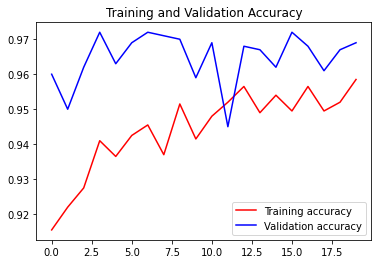

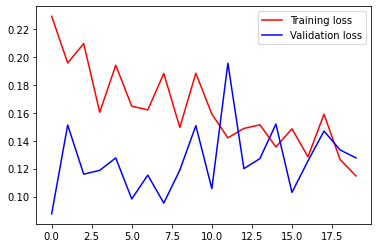

<Figure size 432x288 with 0 Axes>

In [15]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
validation_acc = history.history['val_accuracy']
loss = history.history['loss']
validation_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc,'r',label='Training accuracy')
plt.plot(epochs,validation_acc, 'b',label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.legend(loc=0)

plt.figure()
plt.plot(epochs,loss,'r',label='Training loss')
plt.plot(epochs,validation_loss,'b',label='Validation loss')
plt.legend(loc=0)
plt.figure()

The validation acc and training acc are in sync. This is a good sign of not over fitting